# Challenge
Now that you have two new regression methods at your fingertips, it's time to give them a spin. In fact, for this challenge, let's put them together! Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. If you're drawing a blank, the crime rates in 2013 dataset has a lot of variables that could be made into a modelable binary outcome.

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

Vanilla logistic regression
Ridge logistic regression
Lasso logistic regression
If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

Record your work and reflections in a notebook to discuss with your mentor.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
%matplotlib inline
sns.set_style('white')
import time

# Load and merge data

In [2]:
# country data
CD= pd.read_csv("country_centroids_az8.csv")
CD= CD[['name_long','economy','income_grp','continent','region_un','subregion','Longitude','Latitude']]
CD['name_long']= CD['name_long'].str.lower()
CD= CD.rename(index=str, columns={"name_long": "Country Name"})
CD.head()

,Country Name,economy,income_grp,continent,region_un,subregion,Longitude,Latitude
0,aruba,6. Developing region,2. High income: nonOECD,North America,Americas,Caribbean,-69.982677,12.520880
1,afghanistan,7. Least developed region,5. Low income,Asia,Asia,Southern Asia,66.004734,33.835231
2,angola,7. Least developed region,3. Upper middle income,Africa,Africa,Middle Africa,17.537368,-12.293361
3,anguilla,6. Developing region,3. Upper middle income,North America,Americas,Caribbean,-63.064989,18.223959
4,albania,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.142450


In [3]:
# GDP data
GDP= pd.read_csv("UNdata_Export_20180728_185132879.csv")
# Transform from skinny into wide format
cGDP = GDP.pivot_table(index=['Country or Area','Year'], columns=['Description'],values='Value').reset_index().rename_axis(None, axis=1)
print(cGDP.shape)
cGDP = cGDP[['Country or Area','Year','GDP VOLUME % CHANGE', 'GROSS DOMESTIC PRODUCT']]
cGDP['Year']=cGDP['Year'].apply(int)
cGDP= cGDP.rename(index=str, columns={"Country or Area": "Country Name"})
cGDP['Country Name']= cGDP['Country Name'].str.lower()
print(cGDP.head())

(11733, 261)
         Country Name  Year  GDP VOLUME % CHANGE  GROSS DOMESTIC PRODUCT
0  advanced economies  1968                  NaN                     NaN
1  advanced economies  1969              5.71050                     NaN
2  advanced economies  1970              3.59522                     NaN
3  advanced economies  1971              3.52803                     NaN
4  advanced economies  1972              5.23774                     NaN


In [4]:
# Health and nutrition data
HN= pd.read_csv("morecomplex.csv")
sHN = pd.melt(HN, id_vars=['Country Name', 'Country Code','Indicator Name','Indicator Code'])
sHN=sHN.rename(index=str, columns={"variable": "Year"})

# Transform from skinny into wide format
cHN = sHN.pivot_table(index=['Country Name','Year'], columns=['Indicator Code'],values='value').reset_index().rename_axis(None, axis=1)
cHN['Year']=cHN['Year'].apply(int)
cHN['Country Name']= cHN['Country Name'].str.lower()
print(cHN.shape)
print(cHN.head())

(14448, 347)
  Country Name  Year  NY.GNP.PCAP.CD  SE.ADT.1524.LT.FM.ZS  \
0  afghanistan  1960             NaN                   NaN   
1  afghanistan  1961             NaN                   NaN   
2  afghanistan  1962             NaN                   NaN   
3  afghanistan  1963             NaN                   NaN   
4  afghanistan  1964             NaN                   NaN   

   SE.ADT.1524.LT.MA.ZS  SE.ADT.1524.LT.ZS  SE.ADT.LITR.FE.ZS  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4                   NaN                NaN                NaN   

   SE.ADT.LITR.MA.ZS  SE.ADT.LITR.ZS  SE.ENR.ORPH     ...       \
0                NaN             NaN          NaN     ...        
1                NaN             NaN          NaN     ...        
2                NaN     

In [5]:
# Merge data by Country and Year
print(cHN.shape)
sdf = cHN.merge(cGDP, on=["Country Name","Year"])


# Add country data
print(sdf.shape)
sdf= sdf.merge(CD, on=["Country Name"])
print(sdf.shape)
sdf.head()

(14448, 347)
(7960, 349)
(7464, 356)


,Country Name,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.ENR.ORPH,...,SP.UWT.TFRT,GDP VOLUME % CHANGE,GROSS DOMESTIC PRODUCT,economy,income_grp,continent,region_un,subregion,Longitude,Latitude
0,albania,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.14245
1,albania,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.14245
2,albania,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.14245
3,albania,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.14245
4,albania,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.14245


#  Remove NA

In [6]:
# Remove columns that have only NA for target
# Drop NAs
# How much data is missing in the target column
print('Sum of missing datapoints for GDP volume % change', sdf['SP.DYN.IMRT.IN'].isnull().sum())
# Remove those missing data points
print(sdf.shape)
sdf= sdf[-sdf['SP.DYN.IMRT.IN'].isnull()]
print(sdf.shape)
#print(sdf.head())
print(sdf.shape)

# Remove columns that have only NA
#sdfnona=sdf.dropna(thresh=0.5, axis=1)
#print(sdfnona.shape)

# Keep columns that contain less than 50% Na
criteria=sdf.ix[:,0:356].isnull().sum()<0.5*sdf.shape[0]

sdfLessNa=sdf[criteria.index[criteria]]
print(sdfLessNa.shape)

# Remove the remaining row NA
sdfnona= sdfLessNa.dropna()
print(sdfnona.shape)

Sum of missing datapoints for GDP volume % change 825
(7464, 356)
(6639, 356)
(6639, 356)
(6639, 189)
(1597, 189)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# Prepare data for further steps

In [7]:
# Transform target into categorical
print(sdfnona.shape)
sdfnona['INF_MORT_CHANGE_num'] =  sdfnona['SP.DYN.IMRT.IN'].diff()
sdfnona['INF_MORT_TREND'] = np.where(sdfnona['INF_MORT_CHANGE_num']>0,'up','down') # INF_MORT_TREND 1= up, 0=down
print(sdfnona.shape)
print(sdfnona[['INF_MORT_CHANGE_num','INF_MORT_TREND']].head())

(1597, 189)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(1597, 191)
    INF_MORT_CHANGE_num INF_MORT_TREND
26                  NaN           down
27                 -2.4           down
28                 -2.2           down
29                 -1.9           down
30                 -1.6           down


In [8]:
# Remove Infant mortality data numeric
print(sdfnona.shape)
numtarget =['SP.DYN.IMRT.IN','INF_MORT_CHANGE_num']
sdfnonanot=sdfnona.drop(numtarget, axis=1)
print(sdfnonanot.shape)


(1597, 191)
(1597, 189)


In [9]:
# Split data into categorical and numerical
sdfnona_num = sdfnonanot._get_numeric_data()
print(sdfnona_num.shape)

# scale numeric data
from sklearn.preprocessing import StandardScaler
sdfnona_num_scaled = StandardScaler().fit_transform(sdfnona_num.dropna())
sdfnona_num_scaled = pd.DataFrame(sdfnona_num_scaled, columns = sdfnona_num.columns)
sdfnona_num_scaled2= sdfnona_num_scaled.reset_index(drop=True)

# Drop numeric data columns
sdfnona_cat = sdfnonanot.drop(sdfnona_num_scaled.columns, axis=1)
print(sdfnona_cat.shape)

# generate dummies for categorical data
sdfnona_catdum= pd.get_dummies(sdfnona_cat,drop_first=True)
print(sdfnona_catdum.shape)
sdfnona_catdum2= sdfnona_catdum.reset_index(drop=True)


(1597, 182)
(1597, 7)
(1597, 161)


# Select features based correlation

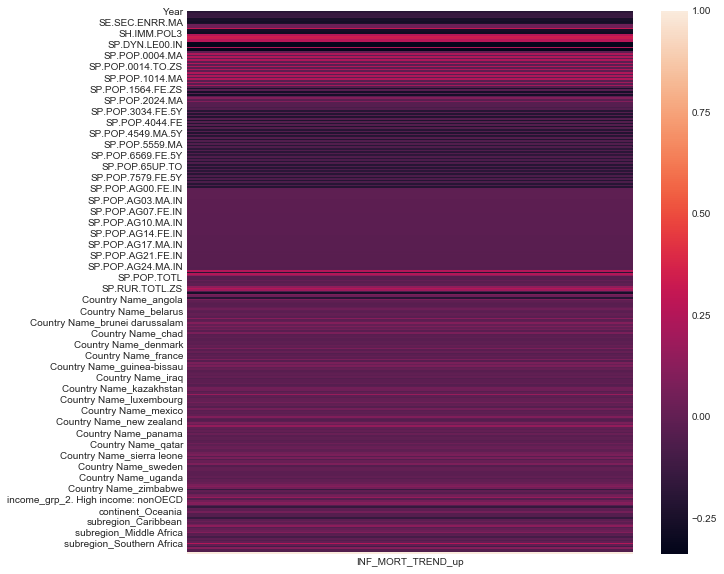

In [10]:
# join numerical and dummy data inlcuding the INF_MORT_TREND
#corrdata= sdfnona_num_scaled.loc(sdfnona_catdum, axis=1)
corrdat = pd.concat([sdfnona_num_scaled2,sdfnona_catdum2], axis=1)

#corrdat['income_grp_3. Upper middle income'].head()
#print(corrdata.shape)
#print(corrdata['income_grp_3. Upper middle income'])

# See which features correlated with the target
CorrMa = corrdat.corr(method='pearson')
#Column names that include loan_status
plt.figure(figsize=(10,10))
sns.heatmap(CorrMa[['INF_MORT_TREND_up']])
plt.show()

In [11]:
# Return the most positively and negatively correlated features 
CorrMa['abs_INF_MORT_TREND']=abs(CorrMa['INF_MORT_TREND_up'])
CorrMa=CorrMa.sort_values(by='abs_INF_MORT_TREND', ascending=False)
CorrMa['INF_MORT_TREND_up'].head(20)

INF_MORT_TREND_up            1.000000
SP.DYN.TO65.FE.ZS           -0.338359
SP.DYN.AMRT.FE               0.336791
SP.DYN.TO65.MA.ZS           -0.336023
SP.DYN.LE00.MA.IN           -0.331426
SP.DYN.LE00.IN              -0.330723
SP.DYN.AMRT.MA               0.327762
SP.DYN.LE00.FE.IN           -0.326470
SH.DYN.MORT                  0.308408
SH.IMM.POL3                 -0.282980
SH.IMM.MEAS                 -0.274909
SH.IMM.IDPT                 -0.263589
SE.SEC.ENRR.MA              -0.262936
SP.DYN.CDRT.IN               0.262900
SP.ADO.TFRT                  0.260201
SE.SEC.ENRR                 -0.256738
SP.POP.DPND                  0.256346
subregion_Southern Africa    0.254175
SP.RUR.TOTL.ZS               0.253521
SP.URB.TOTL.IN.ZS           -0.253521
Name: INF_MORT_TREND_up, dtype: float64

In [12]:
# Select all features that are abs above 0.1
Corrfeaturesdf=CorrMa[CorrMa['abs_INF_MORT_TREND']>0.1]
Corrfeatures= Corrfeaturesdf.index.tolist()
len(Corrfeatures)

91

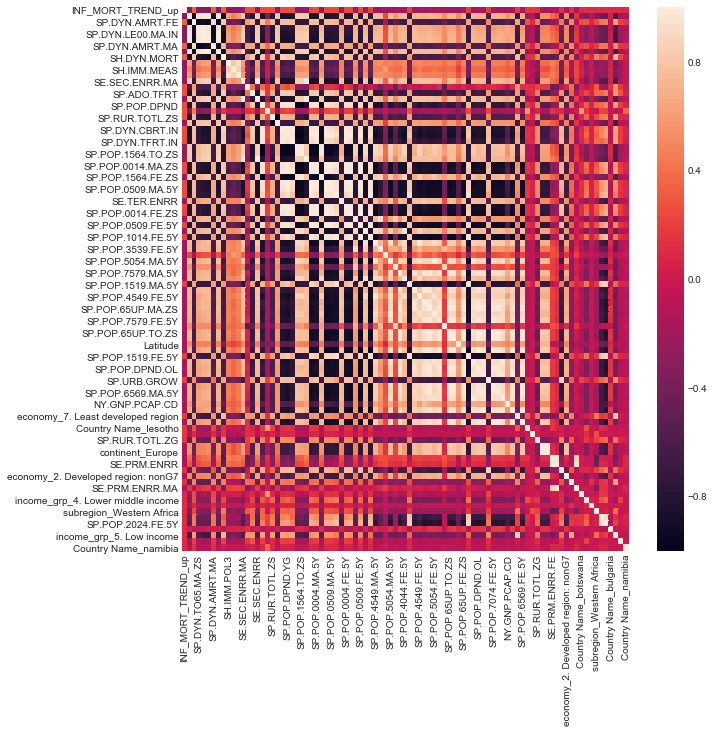

In [13]:
# is there strong correlation between those 91 features?
data= corrdat[Corrfeatures]
CorrMaChosenFeatures=data.corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(CorrMaChosenFeatures)
plt.show()

Looks like there is lots of correlation between features. Probably ridge regression will perform really good.

# Model with correlated features
## Logistic Regression

In [14]:
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression(C=1e9)
    # Very high C=1e9 in order to barely get any l2 penalties
    logreg.fit(input_df, target)
    print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [15]:
# Define data for model
data= corrdat[Corrfeatures]
data.head()
print(data['INF_MORT_TREND_up'].unique())
data= corrdat[Corrfeatures]

target=data['INF_MORT_TREND_up']
dataset= data.drop('INF_MORT_TREND_up', axis=1)

[0 1]


In [16]:
Logit = runLogit(dataset, target,10)

Coefficients Log Regression: [[ 5.10559815e-01  3.65769392e+00 -5.02453374e+00 -4.58974654e-01
   2.90749830e+00 -3.13180843e+00  6.05322317e+00  2.31233594e+00
  -8.90558472e-01 -3.73497329e-01  6.94418472e-01 -6.13298075e-01
   2.02890260e+00 -6.95834316e-01 -9.18025299e-01  7.62255833e+00
   2.52080872e+00  3.36682993e-02 -3.36682994e-02 -1.90066127e+00
   1.63312608e+00 -3.07635604e+00  6.38037384e+00 -9.87159050e+00
   8.66058336e-01 -3.32336835e+00 -1.13804160e+01  5.62391379e+00
  -3.44492163e+00  3.16542743e+00  2.28693614e+00 -9.33168372e-01
   1.03818885e+01  4.96971722e-01 -1.87636709e+00 -9.54136642e+00
   1.12517212e+00 -3.01978975e+00 -7.69626570e-02  2.12978647e+00
  -1.26807295e+00  1.30718759e+00  9.33139604e-01 -7.31784507e+00
  -2.66136043e+00 -1.20162346e+00 -1.76654015e+00  1.04798876e+00
  -3.80301328e+00 -2.25113529e+00 -2.46532869e+00 -1.77757819e+00
  -1.84344409e+00  1.88686451e+01 -2.52546522e+00  1.56443471e-01
  -5.98735245e+00  6.62454472e-01  2.66810741e-

## Ridge Regression

In [17]:
def run_LogitRidge(input_df,target,lambd,n_folds):
    start_time=time.time()
    # Set up the regression model to predict defaults using all other
    # variables as features.
    ridgeregr = linear_model.Ridge(alpha=lambd, fit_intercept=False) 
    
    ridgeregr.fit(input_df, target)
    #print('Coefficients Ridge Regression:',ridgeregr.coef_)
    
    cvs = cross_val_score(ridgeregr, input_df, target, cv=n_folds)
    print(cvs)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [18]:
# Try sevral different values for lambda
RidgeScores=[]
for i in range(0,100,10):
    RidgeScores.append(run_LogitRidge(dataset, target,i,10))
    print()
    print(i)
Ridgelambda20=RidgeScores[1]

[-6.42817784e-02 -2.47414251e+24  1.12915566e-01  4.10344929e-02
 -2.12082183e-01 -3.34842433e+25 -1.67762554e+24 -1.81715468e+00
 -3.22461866e+26 -3.67526389e+25]
Time taken: 0.209 seconds.
Average accuracy: -39685051588274701645905920.000
Standard deviation of accuracy: 100395610996636224956923904.000


0
[ 0.00762269  0.02609859  0.16774351  0.12838479 -0.20211673  0.21201316
  0.13685953  0.17074583  0.22654348  0.0703944 ]
Time taken: 0.081 seconds.
Average accuracy: 0.094
Standard deviation of accuracy: 0.127


10
[ 0.02645654  0.03772021  0.16600066  0.12068203 -0.19801582  0.20699656
  0.13308675  0.17170748  0.22543549  0.06378927]
Time taken: 0.095 seconds.
Average accuracy: 0.095
Standard deviation of accuracy: 0.124


20
[ 0.03582566  0.04137763  0.16311137  0.11535068 -0.19104738  0.20375917
  0.13331115  0.16790687  0.22286486  0.05882051]
Time taken: 0.089 seconds.
Average accuracy: 0.095
Standard deviation of accuracy: 0.120


30
[ 0.04204028  0.04309921  0.16073543  0.

## Lasso Regression

In [19]:
def run_LogitLasso(dataset,target,lambd,n_folds):
    start_time=time.time()
    # Set up the regression model to predict defaults using all other
    # variables as features.
    lasso = linear_model.Lasso(alpha=lambd, fit_intercept=False) 
    #print('X_train:',X_train.head())
    cvs = cross_val_score(lasso, dataset, target, cv=n_folds)
    print(cvs)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [20]:
# Try sevral different values for lambda
LassoScores=[]
for i in range(1,100,10):
    print()
    print(i)
    LassoScores.append(run_LogitLasso(dataset, target,i,10))
Lasso=LassoScores[0]


1
[-0.06666667 -0.22137405 -0.05263158 -0.06666667 -0.05263158 -0.18518519
 -0.11888112 -0.05298013 -0.11971831 -0.09655172]
Time taken: 0.085 seconds.
Average accuracy: -0.103
Standard deviation of accuracy: 0.059

11
[-0.06666667 -0.22137405 -0.05263158 -0.06666667 -0.05263158 -0.18518519
 -0.11888112 -0.05298013 -0.11971831 -0.09655172]
Time taken: 0.069 seconds.
Average accuracy: -0.103
Standard deviation of accuracy: 0.059

21
[-0.06666667 -0.22137405 -0.05263158 -0.06666667 -0.05263158 -0.18518519
 -0.11888112 -0.05298013 -0.11971831 -0.09655172]
Time taken: 0.082 seconds.
Average accuracy: -0.103
Standard deviation of accuracy: 0.059

31
[-0.06666667 -0.22137405 -0.05263158 -0.06666667 -0.05263158 -0.18518519
 -0.11888112 -0.05298013 -0.11971831 -0.09655172]
Time taken: 0.063 seconds.
Average accuracy: -0.103
Standard deviation of accuracy: 0.059

41
[-0.06666667 -0.22137405 -0.05263158 -0.06666667 -0.05263158 -0.18518519
 -0.11888112 -0.05298013 -0.11971831 -0.09655172]
Time t

## RFC

In [21]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time
def RFC(input_df, target, no_folds):
    start_time=time.time()
    rand_forest_class = ensemble.RandomForestClassifier()
    cvs = cross_val_score(rand_forest_class, input_df, target, cv=no_folds)
    print(cvs)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [22]:
RFCScores= RFC(dataset,target,10)

[0.9068323  0.7875     0.9        0.89375    0.925      0.84375
 0.89308176 0.88679245 0.89937107 0.91194969]
Time taken: 1.300 seconds.
Average accuracy: 0.885
Standard deviation of accuracy: 0.040


# Feature selection using PCA

In [23]:
# Define data for pca
data= corrdat[Corrfeatures]
data.head()
print(data['INF_MORT_TREND_up'].unique())
data= corrdat[Corrfeatures]

target=data['INF_MORT_TREND_up']
dataset= data.drop('INF_MORT_TREND_up', axis=1)

[0 1]


In [24]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 

def runPCA(input_df,no_cs, target):
    
    pca = PCA(n_components=no_cs)
    Y_sklearn = pca.fit_transform(input_df) # Makes the whole PCA
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        pca.explained_variance_ratio_
    )

    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.plot(var1)
    plt.show()
    # Select the components
    PCA_Features = pd.DataFrame(Y_sklearn)
    return(PCA_Features)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.68220409 0.0918249  0.04065135 0.03128953 0.02464859 0.01809723
 0.01397149 0.01163923 0.00940341 0.00846806]


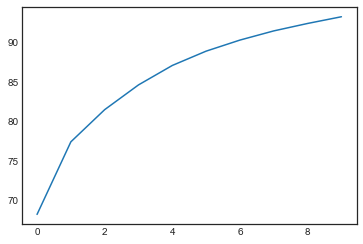

In [25]:
PCAFeatures10=runPCA(dataset,10,target)

## Logistic regression

In [27]:
LogitPCA = runLogit(PCAFeatures10, target,10)

Coefficients Log Regression: [[ 0.12644438 -0.16709425 -0.12166317 -0.15722411 -0.35615111  0.18652809
   0.34851989  0.19774305  0.04227557 -0.2977907 ]]
Time taken: 0.071 seconds.
Average accuracy: 0.902
Standard deviation of accuracy: 0.023


## Ridge regression

In [28]:
# Try sevral different values for lambda
PCARidgeScores=[]
for i in range(0,100,10):
    PCARidgeScores.append(run_LogitRidge(PCAFeatures10, target,i,10))
    print()
    print(i)
PCARidgelambda300=RidgeScores[3]

[ 0.01314275 -0.07643144  0.01244958  0.06718917 -0.19241279  0.01418052
  0.07983745 -0.04918387  0.03398783 -0.03252897]
Time taken: 0.044 seconds.
Average accuracy: -0.013
Standard deviation of accuracy: 0.080


0
[ 0.01340122 -0.0763159   0.01247017  0.06727516 -0.19119826  0.01412665
  0.07963644 -0.04812141  0.03397997 -0.0322093 ]
Time taken: 0.050 seconds.
Average accuracy: -0.013
Standard deviation of accuracy: 0.079


10
[ 0.0136426  -0.07620557  0.01248537  0.06735863 -0.19000082  0.01407147
  0.07943383 -0.04708658  0.0339694  -0.03189642]
Time taken: 0.035 seconds.
Average accuracy: -0.012
Standard deviation of accuracy: 0.079


20
[ 0.01386775 -0.07610024  0.01249541  0.06743965 -0.18882011  0.01401505
  0.07922981 -0.04607837  0.03395621 -0.0315901 ]
Time taken: 0.032 seconds.
Average accuracy: -0.012
Standard deviation of accuracy: 0.079


30
[ 0.01407748 -0.07599972  0.01250047  0.06751827 -0.18765576  0.01395746
  0.07902458 -0.04509581  0.0339405  -0.03129014]
Time t

## Lasso regression

In [29]:
# Try sevral different values for lambda
PCALassoScores=[]
for i in range(0,1000,10):
    PCALassoScores.append(run_LogitRidge(PCAFeatures10, target,i,10))
    print()
    print(i)
PCALasso=PCALassoScores[0]

[ 0.01314275 -0.07643144  0.01244958  0.06718917 -0.19241279  0.01418052
  0.07983745 -0.04918387  0.03398783 -0.03252897]
Time taken: 0.035 seconds.
Average accuracy: -0.013
Standard deviation of accuracy: 0.080


0
[ 0.01340122 -0.0763159   0.01247017  0.06727516 -0.19119826  0.01412665
  0.07963644 -0.04812141  0.03397997 -0.0322093 ]
Time taken: 0.041 seconds.
Average accuracy: -0.013
Standard deviation of accuracy: 0.079


10
[ 0.0136426  -0.07620557  0.01248537  0.06735863 -0.19000082  0.01407147
  0.07943383 -0.04708658  0.0339694  -0.03189642]
Time taken: 0.045 seconds.
Average accuracy: -0.012
Standard deviation of accuracy: 0.079


20
[ 0.01386775 -0.07610024  0.01249541  0.06743965 -0.18882011  0.01401505
  0.07922981 -0.04607837  0.03395621 -0.0315901 ]
Time taken: 0.030 seconds.
Average accuracy: -0.012
Standard deviation of accuracy: 0.079


30
[ 0.01407748 -0.07599972  0.01250047  0.06751827 -0.18765576  0.01395746
  0.07902458 -0.04509581  0.0339405  -0.03129014]
Time t

[ 0.01559288 -0.07444521  0.01044697  0.06915574 -0.15358227  0.01137753
  0.071472   -0.02088281  0.03222761 -0.02331408]
Time taken: 0.039 seconds.
Average accuracy: -0.006
Standard deviation of accuracy: 0.068


410
[ 0.01554103 -0.07444003  0.01035442  0.06917407 -0.15285285  0.01130226
  0.07128123 -0.02044947  0.03216251 -0.02315786]
Time taken: 0.046 seconds.
Average accuracy: -0.006
Standard deviation of accuracy: 0.067


420
[ 0.01548672 -0.07443603  0.01026076  0.06919138 -0.15213138  0.01122692
  0.07109144 -0.02002398  0.03209684 -0.02300385]
Time taken: 0.032 seconds.
Average accuracy: -0.006
Standard deviation of accuracy: 0.067


430
[ 0.01543004 -0.07443318  0.01016604  0.06920768 -0.15141774  0.01115151
  0.07090264 -0.01960613  0.03203063 -0.022852  ]
Time taken: 0.029 seconds.
Average accuracy: -0.006
Standard deviation of accuracy: 0.067


440
[ 0.0153711  -0.07443145  0.01007031  0.069223   -0.15071181  0.01107605
  0.07071483 -0.01919573  0.03196389 -0.02270227]
T

[ 0.01207    -0.07495475  0.00587714  0.06921771 -0.12811229  0.00816279
  0.06415787 -0.00749896  0.02911876 -0.01813004]
Time taken: 0.039 seconds.
Average accuracy: -0.004
Standard deviation of accuracy: 0.060


840
[ 0.01197253 -0.07497823  0.00576394  0.06920555 -0.12763672  0.00809002
  0.06400841 -0.00728096  0.02904267 -0.01803789]
Time taken: 0.034 seconds.
Average accuracy: -0.004
Standard deviation of accuracy: 0.060


850
[ 0.01187485 -0.07500203  0.00565068  0.06919293 -0.12716541  0.00801737
  0.06385981 -0.00706599  0.02896652 -0.01794671]
Time taken: 0.033 seconds.
Average accuracy: -0.004
Standard deviation of accuracy: 0.060


860
[ 0.01177697 -0.07502614  0.00553736  0.06917985 -0.12669832  0.00794486
  0.06371206 -0.006854    0.02889033 -0.01785649]
Time taken: 0.041 seconds.
Average accuracy: -0.004
Standard deviation of accuracy: 0.059


870
[ 0.0116789  -0.07505056  0.00542399  0.06916632 -0.1262354   0.00787248
  0.06356516 -0.00664493  0.0288141  -0.01776721]
T

## RFC

In [30]:
PCARFCScores= RFC(PCAFeatures10,target,10)

[0.88198758 0.875      0.91875    0.90625    0.91875    0.8125
 0.90566038 0.91194969 0.88050314 0.91823899]
Time taken: 0.583 seconds.
Average accuracy: 0.893
Standard deviation of accuracy: 0.033


# Results

      Logit  Ridgelambda2     Lasso       RFC  LogitPCA  PCARidgelambda30  \
0  0.906832      0.007623 -0.066667  0.906832  0.906832          0.035826   
1  0.800000      0.026099 -0.221374  0.787500  0.881250          0.041378   
2  0.906250      0.167744 -0.052632  0.900000  0.918750          0.163111   
3  0.893750      0.128385 -0.066667  0.893750  0.906250          0.115351   
4  0.812500     -0.202117 -0.052632  0.925000  0.906250         -0.191047   

   PCALasso    PCARFC  
0  0.013143  0.881988  
1 -0.076431  0.875000  
2  0.012450  0.918750  
3  0.067189  0.906250  
4 -0.192413  0.918750  


Text(0.5,0,'Models tried')

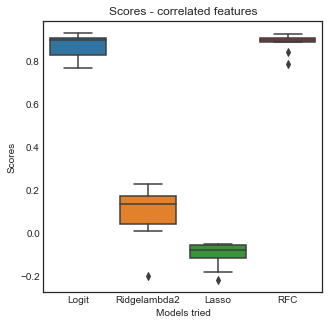

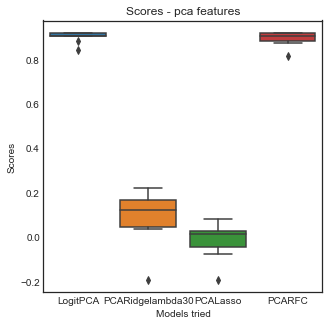

In [31]:
Scores = {'Logit': Logit,'Ridgelambda2':Ridgelambda20,'Lasso':Lasso,'RFC':RFCScores,
          'LogitPCA':LogitPCA,'PCARidgelambda30':PCARidgelambda300,'PCALasso': PCALasso,'PCARFC': PCARFCScores}
Scoreresults = pd.DataFrame(data=Scores, index=(range(10)))
print(Scoreresults.head())


# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[['Logit','Ridgelambda2','Lasso','RFC']], ax=ax)
im.set_title('Scores - correlated features')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')
# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[['LogitPCA','PCARidgelambda30','PCALasso','PCARFC']], ax=ax)
im.set_title('Scores - pca features')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

Logistic regression yields the best scores, compared to Lasso and Ridge, with R^2 of over 0.8. The accurancy has less error when using the PCA features, then using the best correlated features.
Maybe Ridge does not work because of high collinearity of the features I chose.However, I have no explanation why Lasso did not perform well. Maybe I did not test the lambda value in the correct range.

In [ ]:
#https://stats.stackexchange.com/questions/254124/why-does-logistic-regression-become-unstable-when-classes-are-well-separated
# Why do I get this result - intuitive understanding of the process on the data
#